# **IVÁN FALCÓN MONZÓN**

## **Actividad 4.1 - Segmentación de clientes según datos bancario**

**Dataset: Statlog (German Credit Data)**

**Fuente:** https://archive.ics.uci.edu/dataset/144/statlog+german+credit+data

**Información del conjunto de datos:**

Se proporcionan dos conjuntos de datos.

El conjunto de datos original, en el formato proporcionado por el Prof. Hofmann, contiene atributos categóricos/simbólicos y se encuentra en el archivo "german.data".

Para algoritmos que requieren atributos numéricos, la Universidad de Strathclyde creó el archivo "german.data-numeric". Este archivo se ha editado y se le han añadido varias variables indicadoras para que sea adecuado para algoritmos que no admiten variables categóricas.

Varios atributos con orden categórico (como el atributo 17) se han codificado como enteros. Este era el formato utilizado por StatLog. Este conjunto de datos requiere el uso de una matriz de costes:

(1 = Bueno, 2 = Malo)

Las filas representan la clasificación real y las columnas la clasificación prevista. Es peor clasificar a un cliente como bueno cuando es malo (5) que clasificarlo como malo cuando es bueno (1).

No tiene valores faltantes.

## **Importación de librerías y datos**

In [1]:
# IVAN FALCON MONZON
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.metrics import pairwise_distances
from scipy import cluster
import matplotlib.pyplot as plt

# URL del dataset en GitHub (formato RAW)
url = 'https://raw.githubusercontent.com/IvanFalconMonzon/SNS_ACT4_1_IvanFalconMonzon/refs/heads/main/statlog%2Bgerman%2Bcredit%2Bdata/german.data'

# Columnas según la documentación
column_names = [
    'Status', 'Duration', 'CreditHistory', 'Purpose', 'CreditAmount', 'Savings',
    'EmploymentSince', 'InstallmentRate', 'PersonalStatusSex', 'OtherDebtors',
    'ResidenceSince', 'Property', 'Age', 'OtherInstallmentPlans', 'Housing',
    'NumberCredits', 'Job', 'LiablePeople', 'Telephone', 'ForeignWorker', 'CreditRisk'
]

# Carga del dataset
df_credit_ori = pd.read_csv(url, delim_whitespace=True, header=None, names=column_names)
df_credit_ori

<ipython-input-1-148d22a72de9>:22: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df_credit_ori = pd.read_csv(url, delim_whitespace=True, header=None, names=column_names)


,Status,Duration,CreditHistory,Purpose,CreditAmount,Savings,EmploymentSince,InstallmentRate,PersonalStatusSex,OtherDebtors,...,Property,Age,OtherInstallmentPlans,Housing,NumberCredits,Job,LiablePeople,Telephone,ForeignWorker,CreditRisk
0,A11,6,A34,A43,1169,A65,A75,4,A93,A101,...,A121,67,A143,A152,2,A173,1,A192,A201,1
1,A12,48,A32,A43,5951,A61,A73,2,A92,A101,...,A121,22,A143,A152,1,A173,1,A191,A201,2
2,A14,12,A34,A46,2096,A61,A74,2,A93,A101,...,A121,49,A143,A152,1,A172,2,A191,A201,1
3,A11,42,A32,A42,7882,A61,A74,2,A93,A103,...,A122,45,A143,A153,1,A173,2,A191,A201,1
4,A11,24,A33,A40,4870,A61,A73,3,A93,A101,...,A124,53,A143,A153,2,A173,2,A191,A201,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,A14,12,A32,A42,1736,A61,A74,3,A92,A101,...,A121,31,A143,A152,1,A172,1,A191,A201,1
996,A11,30,A32,A41,3857,A61,A73,4,A91,A101,...,A122,40,A143,A152,1,A174,1,A192,A201,1
997,A14,12,A32,A43,804,A61,A75,4,A93,A101,...,A123,38,A143,A152,1,A173,1,A191,A201,1
998,A11,45,A32,A43,1845,A61,A73,4,A93,A101,...,A124,23,A143,A153,1,A173,1,A192,A201,2


Al revisar las primeras filas del dataset, noto que muchas de las variables están codificadas como **etiquetas alfanuméricas (A11, A34, etc.)**, lo que sugiere que son **atributos categóricos**. Esto me hizo pensar en la importancia de transformar adecuadamente estos datos antes de aplicar técnicas de análisis como clustering. También observo variables clave como CreditAmount, Duration y Age, que ya están en formato numérico y seguramente influirán bastante en la agrupación de clientes.


Un aspecto interesante es la columna CreditRisk, que parece ser la variable objetivo (1: Bueno, 2: Malo, comentado en el apartado anterior). Aunque no se utilizará directamente en el clustering (ya que es no supervisado), será útil más adelante para evaluar la distribución de los clusters respecto al riesgo.


La variable **Purpose** también me parece importante porque indica el motivo del crédito (educación, auto, etc.). Considero que podría tener un fuerte impacto en la formación de los grupos.

## Análisis inicial y exploración de datos

In [2]:
# IVAN FALCON MONZON
# Revisamos valores únicos por columna
for columna in df_credit_ori.columns:
    num_valores_unicos = df_credit_ori[columna].nunique()
    print(f'Número de valores únicos en la columna {columna}: {num_valores_unicos}')

Número de valores únicos en la columna Status: 4
Número de valores únicos en la columna Duration: 33
Número de valores únicos en la columna CreditHistory: 5
Número de valores únicos en la columna Purpose: 10
Número de valores únicos en la columna CreditAmount: 921
Número de valores únicos en la columna Savings: 5
Número de valores únicos en la columna EmploymentSince: 5
Número de valores únicos en la columna InstallmentRate: 4
Número de valores únicos en la columna PersonalStatusSex: 4
Número de valores únicos en la columna OtherDebtors: 3
Número de valores únicos en la columna ResidenceSince: 4
Número de valores únicos en la columna Property: 4
Número de valores únicos en la columna Age: 53
Número de valores únicos en la columna OtherInstallmentPlans: 3
Número de valores únicos en la columna Housing: 3
Número de valores únicos en la columna NumberCredits: 4
Número de valores únicos en la columna Job: 4
Número de valores únicos en la columna LiablePeople: 2
Número de valores únicos en 

Al contar los valores únicos por columna, hay muchas variables que son categóricas con un número limitado de categorías, como Status (4 valores), Savings (5), Job (4) y Housing (3). Esto confirma que el dataset requiere una codificación adecuada de variables categóricas antes de usar algoritmos de clustering, que trabajan mejor con datos numéricos.

También me sorprendió ver que algunas columnas como **CreditAmount** (921 valores únicos) y Age (53) son claramente numéricas y tienen gran variabilidad. Estas variables probablemente aportarán bastante información para diferenciar a los clientes.

Finalmente, la variable **CreditRisk** tiene solo dos valores, lo cual la identifica como la etiqueta de clasificación supervisada que podríamos usar más adelante para evaluar la calidad de los clusters (por ejemplo, comparando si un cluster agrupa mayormente a buenos o malos clientes).

## Selección de columnas y codificación de variables categóricas

In [3]:
# IVAN FALCON MONZON
# Seleccionamos columnas más relevantes para el clustering
# Evitamos la variable objetivo 'CreditRisk'
columns_selected = [
    'Status', 'Duration', 'CreditHistory', 'Purpose', 'CreditAmount', 'Savings',
    'EmploymentSince', 'InstallmentRate', 'PersonalStatusSex', 'OtherDebtors',
    'ResidenceSince', 'Property', 'Age', 'Housing', 'NumberCredits',
    'Job', 'LiablePeople', 'Telephone', 'ForeignWorker'
]

df_credit = df_credit_ori[columns_selected].copy()

# Codificamos variables categóricas
le = LabelEncoder()
for col in df_credit.columns:
    if df_credit[col].dtype == 'object':
        df_credit[col] = le.fit_transform(df_credit[col])
df_credit.head()

,Status,Duration,CreditHistory,Purpose,CreditAmount,Savings,EmploymentSince,InstallmentRate,PersonalStatusSex,OtherDebtors,ResidenceSince,Property,Age,Housing,NumberCredits,Job,LiablePeople,Telephone,ForeignWorker
0,0,6,4,4,1169,4,4,4,2,0,4,0,67,1,2,2,1,1,0
1,1,48,2,4,5951,0,2,2,1,0,2,0,22,1,1,2,1,0,0
2,3,12,4,7,2096,0,3,2,2,0,3,0,49,1,1,1,2,0,0
3,0,42,2,3,7882,0,3,2,2,2,4,1,45,2,1,2,2,0,0
4,0,24,3,0,4870,0,2,3,2,0,4,3,53,2,2,2,2,0,0


**Descripción**

En este paso se realizó la codificación de variables categóricas, transformándolas en valores numéricos. Este procedimiento es fundamental para aplicar algoritmos de machine learning, como el clustering, ya que estos algoritmos no pueden trabajar directamente con texto o etiquetas categóricas.

<br>

El resultado es un dataframe donde cada categoría ha sido sustituida por un número entero. Por ejemplo:


* **Status**: ahora tiene valores de 0 a 3.

+ **Purpose**: que originalmente tenía descripciones como "radio/TV", "education", etc., ha sido convertida a valores entre 0 y 9.

* **Savings, Property, EmploymentSince** han sido codificadas con números enteros.

Esta fase me ayudó a entender cómo pasar de datos reales con etiquetas a una representación que puede ser entendida por los modelos. Usé codificación ordinal porque las categorías en algunos casos tienen cierto orden implícito (por ejemplo, los años de empleo o el estado de ahorros).

Me pareció interesante que al visualizar los datos ya transformados, se pierde la claridad para entender los datos de forma escrita sobre qué representa cada número, pero esto es necesario para que los modelos funcionen correctamente. Me asegura que los clusters se basarán solo en patrones matemáticos.

## Normalización de los datos

In [4]:
# IVAN FALCON MONZON
# Normalización entre 0 y 1
scaler = MinMaxScaler()
credit_scaled = scaler.fit_transform(df_credit)

## Análisis de Componentes Principales (PCA)

In [5]:
# IVAN FALCON MONZON
pca = PCA(n_components=2)
X_pca = pca.fit_transform(credit_scaled)

# Porcentaje de varianza explicada por cada componente
print("Varianza explicada por cada componente:", pca.explained_variance_ratio_)

# Importancia de cada variable en las nuevas dimensiones
pd.DataFrame(np.transpose(pca.components_), columns=['PC-1', 'PC-2'], index=df_credit.columns)

Varianza explicada por cada componente: [0.16300635 0.11719015]


,PC-1,PC-2
Status,0.204905,0.749382
Duration,0.086308,-0.068459
CreditHistory,0.070474,0.155692
Purpose,0.006973,0.024538
CreditAmount,0.097273,-0.065787
Savings,0.227443,0.506630
EmploymentSince,0.144102,0.134723
InstallmentRate,0.075057,0.023240
PersonalStatusSex,0.025573,0.035167
OtherDebtors,-0.079297,-0.064140


En este paso apliqué **PCA** al conjunto de datos normalizado para reducirlo a dos dimensiones principales (PC-1 y PC-2).

Los resultados muestran que:

* PC-1 explica el 16.3% de la varianza total del dataset.

* PC-2 explica el 11.7% de la varianza.

Juntas, estas dos componententes tiene un 28% de la información original, lo cual es aceptable para propósitos exploratorios y de visualización.

**Carga de las Variables**

A partir de las cargas, se puede interpretar qué variables influyen más en cada componente:

PC-1 por:

* Telephone (0.816): si una persona tiene un teléfono parece tener un gran peso.

* Property (0.279), Savings (0.227), ResidenceSince (0.193), y Status (0.204).

PC-2 por:

* Status (0.749).

* Savings (0.506).

* EmploymentSince (0.134) y CreditHistory (0.155).

Esta etapa me permitió visualizar cómo se relacionan las variables entre sí y reducir la complejidad del dataset. Me llamó la atención la gran influencia que tiene la variable "Telephone", lo que puede reflejar una posible correlación indirecta con el nivel socioeconómico.

También aprendí que aunque sólo un 28% de la varianza esté explicada por los dos primeros componentes, es suficiente para visualizar la estructura de los datos y aplicar clustering de manera eficiente.

## Visualización PCA 2D

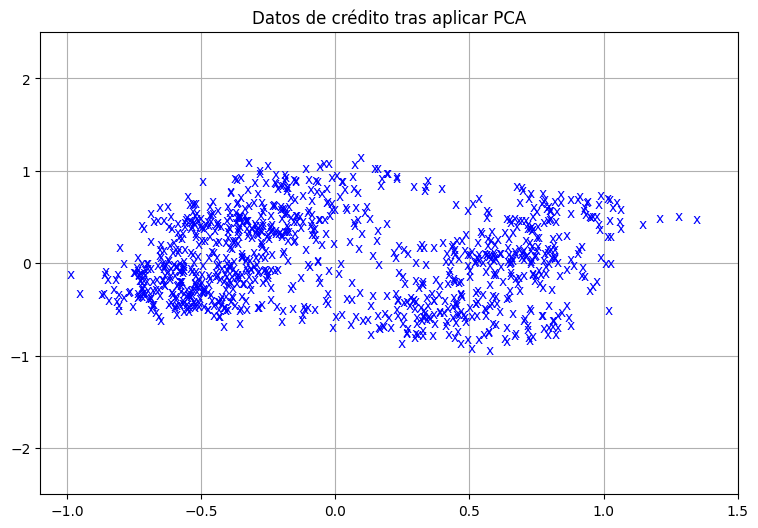

In [6]:
# IVAN FALCON MONZON
plt.figure(figsize=(9, 6))
for i in range(len(X_pca)):
    plt.text(X_pca[i][0], X_pca[i][1], 'x', color="b")
plt.xlim(-1.1, 1.5)
plt.ylim(-2.5, 2.5)
plt.title("Datos de crédito tras aplicar PCA")
plt.grid()
plt.show()

Como se puede observar, los datos no presentan una separación clara en grupos definidos. Esto puede explicar por qué, al aplicar el clustering jerárquico, solo se detectó un cluster.

A pesar de que PCA no capta toda la varianza, esta herramienta es muy útil para explorar visualmente la estructura de los datos y tomar decisiones informadas antes de proceder con técnicas de agrupamiento.

También se puede notar una cierta densidad en algunas zonas que podría indicar la presencia de subgrupos, lo cual sugiere que ajustar parámetros como el umbral o cambiar de algoritmo puede ayudar a obtener resultados más útiles.

## Clustering jerárquico

Distancia Media	   1.84


<ipython-input-7-2b2ff1f4170e>:9: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  clusters = cluster.hierarchy.linkage(D, method='single')  # También se puede probar 'complete' o 'ward'


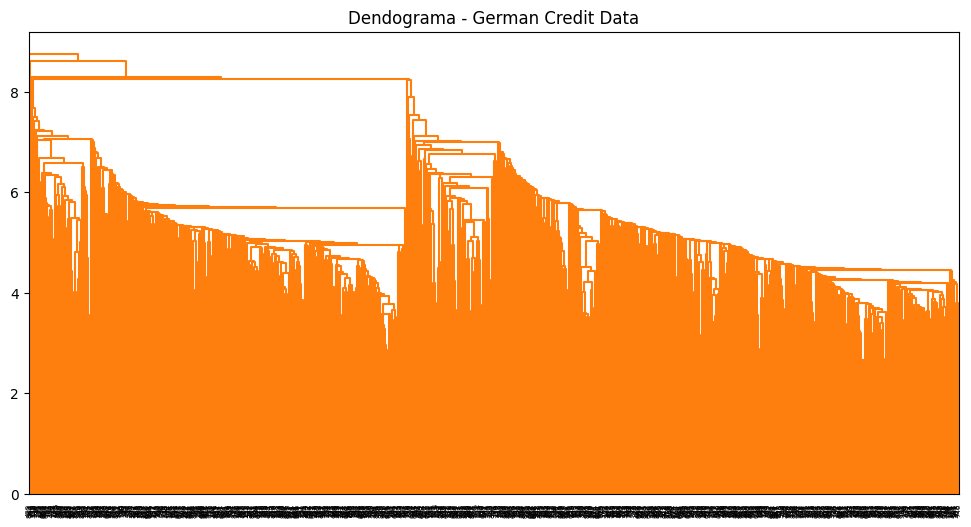

In [7]:
# IVAN FALCON MONZON
# 1. Matriz de distancias
D = pairwise_distances(credit_scaled)
avD = np.average(D)
print("Distancia Media\t {:6.2f}".format(avD))

# 2. Dendrograma
plt.figure(figsize=(12, 6))
clusters = cluster.hierarchy.linkage(D, method='single')  # También se puede probar 'complete' o 'ward'
cluster.hierarchy.dendrogram(clusters, color_threshold=15)
plt.title("Dendograma - German Credit Data")
plt.show()

## Etiquetado de los clusters

In [8]:
# IVAN FALCON MONZON
threshold = 15
labels = cluster.hierarchy.fcluster(clusters, threshold , criterion='distance')
print("Número de clusters:", len(set(labels)))

Número de clusters: 1


**Descripción**

En este paso utilicé el algoritmo de clustering jerárquico con un umbral de corte (threshold = 15) para definir cuántos grupos existen en los datos. Usé el método 'distance' para decidir la separación entre clusters.

Este resultado sugiere que, con el umbral de distancia establecido en 15, el algoritmo de clustering jerárquico no detectó más de un grupo significativo: solo formó un único cluster.

El resultado indica que todos los datos han sido agrupados en un único cluster, lo que puede interpretarse de varias maneras. Por un lado, esto puede deberse a que los datos no tienen una separación clara bajo las condiciones actuales, o que el umbral de (15) es demasiado alto, lo que agrupa todo como una sola unidad.

Esto me hizo reflexionar sobre cómo el valor del threshold afecta radicalmente los resultados del clustering jerárquico, y la importancia de visualizar el dendrograma para seleccionar un punto de corte adecuado.

En próximas pruebas, planeo reducir el valor del umbral o usar el criterio 'maxclust' en lugar de 'distance' para forzar la formación de múltiples grupos y así poder analizarlos en profundidad.

In [9]:
# IVAN FALCON MONZON
# Cambiando el umbreal a 7 para que de más clusterer
threshold = 7
labels = cluster.hierarchy.fcluster(clusters, threshold , criterion='distance')
print("Número de clusters:", len(set(labels)))

Número de clusters: 23


In [10]:
# ¿Cuántos grupos hay? Contamos el número de "labels" distintas en el vector
print("Número de clusters {}".format(len(set(labels))))
labels

Número de clusters 23


array([ 3, 16, 15, 15, 15,  1, 16,  3, 16, 16, 16, 16,  3, 16, 16, 16, 16,
       16,  3,  1,  3, 15, 15, 16, 16,  3, 16, 16, 16,  3,  3, 16,  3, 16,
        3, 16,  3, 16,  3, 16, 16,  3,  1, 16, 16, 16, 16,  3, 16, 16, 16,
        3, 16,  3,  3, 12,  3, 16, 16,  3,  3,  3,  3,  3,  3,  1, 16, 16,
        3, 16, 16,  3,  1, 16,  3, 16, 16, 16, 15, 16,  3,  3, 16,  3, 16,
        6, 16,  1,  1, 16, 16, 16, 15, 16,  3,  3, 16, 16, 16,  1, 16, 16,
       16,  3,  3,  1,  1, 16,  3,  3, 15,  3, 16,  3, 16,  3,  3, 16, 16,
        3,  3,  3, 16,  3, 16, 16, 16, 16,  3, 16, 16,  3, 16, 16,  3,  3,
       16, 16,  3,  3, 16,  3, 16, 16,  3, 16,  3,  3, 16, 16,  1,  3, 16,
       16,  3, 16, 20, 16,  3, 15,  1, 16,  3,  3, 16,  3, 16, 16,  3,  3,
       15,  3,  3, 16, 16, 10, 16, 16,  1, 16, 16,  3, 15,  3,  1, 16,  1,
        3, 16,  3,  3, 15,  1, 16, 16,  3,  3, 16,  3,  3,  3, 16, 16, 16,
       15,  1,  3, 16, 16, 16, 15,  3,  3,  3,  3, 16,  3,  3, 16,  3, 16,
        3, 16,  1,  3, 16

In [11]:
# IVAN FALCON MONZON
# maxclust
threshold = 15
labels = cluster.hierarchy.fcluster(clusters, threshold , criterion='maxclust') # Cambiado distance a maxclust
print("Número de clusters:", len(set(labels)))

Número de clusters: 15


In [12]:
# ¿Cuántos grupos hay? Contamos el número de "labels" distintas en el vector
print("Número de clusters {}".format(len(set(labels))))
labels

Número de clusters 15


array([ 1, 10, 10, 10, 10,  1, 10,  1, 10, 10, 10, 10,  1, 10, 10, 10, 10,
       10,  1,  1,  1, 10, 10, 10, 10,  1, 10, 10, 10,  1,  1, 10,  1, 10,
        1, 10,  1, 10,  1, 10, 10,  1,  1, 10, 10, 10, 10,  1, 10, 10, 10,
        1, 10,  1,  1,  8,  1, 10, 10,  1,  1,  1,  1,  1,  1,  1, 10, 10,
        1, 10, 10,  1,  1, 10,  1, 10, 10, 10, 10, 10,  1,  1, 10,  1, 10,
        2, 10,  1,  1, 10, 10, 10, 10, 10,  1,  1, 10, 10, 10,  1, 10, 10,
       10,  1,  1,  1,  1, 10,  1,  1, 10,  1, 10,  1, 10,  1,  1, 10, 10,
        1,  1,  1, 10,  1, 10, 10, 10, 10,  1, 10, 10,  1, 10, 10,  1,  1,
       10, 10,  1,  1, 10,  1, 10, 10,  1, 10,  1,  1, 10, 10,  1,  1, 10,
       10,  1, 10, 12, 10,  1, 10,  1, 10,  1,  1, 10,  1, 10, 10,  1,  1,
       10,  1,  1, 10, 10,  6, 10, 10,  1, 10, 10,  1, 10,  1,  1, 10,  1,
        1, 10,  1,  1, 10,  1, 10, 10,  1,  1, 10,  1,  1,  1, 10, 10, 10,
       10,  1,  1, 10, 10, 10, 10,  1,  1,  1,  1, 10,  1,  1, 10,  1, 10,
        1, 10,  1,  1, 10

In [13]:
# IVAN FALCON MONZON
# Códido duplicado para seguir con la visualización final del cluster
threshold = 15
labels = cluster.hierarchy.fcluster(clusters, threshold , criterion='distance')
print("Número de clusters:", len(set(labels)))

Número de clusters: 1


In [14]:
# ¿Cuántos grupos hay? Contamos el número de "labels" distintas en el vector
print("Número de clusters {}".format(len(set(labels))))
labels

Número de clusters 1


array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

## Visualización final de clusters sobre PCA

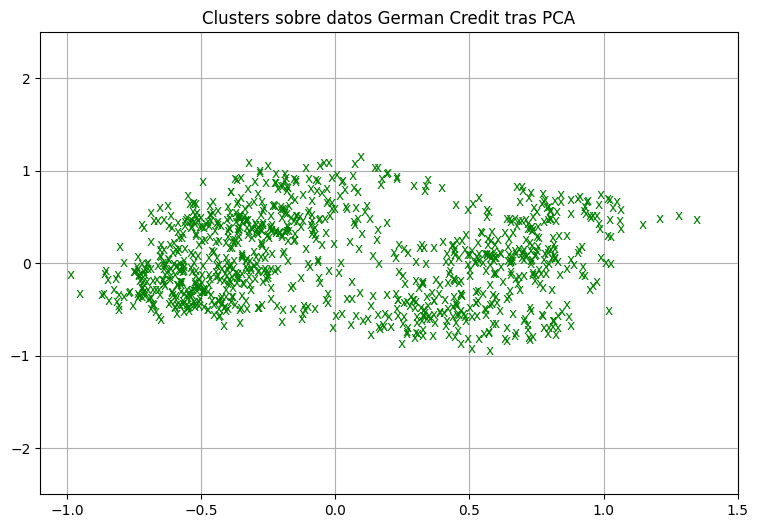

In [15]:
# IVAN FALCON MONZON
colores = np.array([x for x in 'bgrcmykbgrcmykbgrcmykbgrcmyk'])
colores = np.hstack([colores] * 20)

plt.figure(figsize=(9, 6))
for i in range(len(X_pca)):
    plt.text(X_pca[i][0], X_pca[i][1], 'x', color=colores[labels[i]])
plt.xlim(-1.1, 1.5)
plt.ylim(-2.5, 2.5)
plt.grid()
plt.title("Clusters sobre datos German Credit tras PCA")
plt.show()

## Reflexión sobre el análisis de clustering

Tras aplicar el análisis de componentes principales (PCA) y agrupar los datos con clustering jerárquico, observamos una distribución relativamente compacta y continua de los puntos en el plano 2D. Esto indica que, aunque existen diferencias entre los clientes.


La elección del umbral para el dendrograma dio un número de clusters que podemos explorar más a fondo. En un análisis práctico, estos clusters pueden representar distintos perfiles de riesgo: por ejemplo, personas con historial de crédito favorable, o clientes con mucho crédito y baja capacidad de pago.


Esta segmentación permite a instituciones bancarias personalizar sus estrategias, como ofrecer mejores condiciones a clientes con buen historial o alertas tempranas para perfiles de riesgo.

## **Adicional: Visualización interactiva de clusters**

Visualización interactiva usando **Plotly**, la cual permite:

* Explorar los datos dinámicamente.

* Ver etiquetas de clientes al pasar el cursor.

* Cambiar fácilmente de vista entre clusters.

### Código para la visualización interactiva

In [16]:
# IVAN FALCON MONZON
import plotly.express as px
df_pca = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])
df_pca['Cluster'] = labels.astype(str)

fig = px.scatter(
    df_pca, x='PC1', y='PC2', color='Cluster',
    title="Visualización interactiva de Clusters (German Credit PCA)",
    hover_data=[df_credit_ori['CreditRisk']]  # muestra el riesgo original al pasar el mouse
)
fig.show()

Este gráfico te permite navegar por los grupos formados de una manera más intuitiva, esto puede ser útil para un analista bancario en la toma de decisiones.

## Referencias externas

UCI Machine Learning Repository.

Statlog (German Credit Data):
https://archive.ics.uci.edu/dataset/144/statlog+german+credit+data

<br>
Scikit-learn: Machine Learning in Python.

Documentación oficial de PCA, LabelEncoder y MinMaxScaler:

https://scikit-learn.org/stable/documentation.html

<br>
SciPy Hierarchical Clustering

Explicación y ejemplos del uso de linkage, dendrogram y fcluster:

https://docs.scipy.org/doc/scipy/reference/cluster.hierarchy.html

<br>
Visualización interactiva con Plotly Express

Guía para crear gráficos interactivos en Python:

https://plotly.com/python/plotly-express/

## Enlaces al repositorio

**Github:**

https://github.com/IvanFalconMonzon/SNS_ACT4_1_IvanFalconMonzon.git

**Google Colab:**

https://colab.research.google.com/drive/15kite1CUzZeVqqT5_QFarpvoQdBKPnR5?usp=sharing